In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torch.utils.data as data


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Lấy dữ liệu và kiểm tra

In [3]:
import ast
# Đọc dữ liệu từ file CSV
df_train = pd.read_csv('Data_training_v2.csv')
#df_train = pd.read_csv('Data_training.csv')


# Chọn các cột 'x1', 'x2', 'x3', 'x4', 'x5' làm đầu vào và 'y' làm đầu ra
x_train_data = df_train[['x1', 'x2', 'x3', 'x4', 'x5']]
y_train_data = df_train['y']

# Khởi tạo danh sách để lưu trữ dữ liệu đầu vào dưới dạng tensors
x_train = []

# Lặp qua từng hàng trong x_data
for index in range(len(x_train_data)):
    # Lấy hàng thứ index từ DataFrame
    row = x_train_data.iloc[index]
    # Chuyển đổi từng giá trị trong hàng thành list
    x_values = [ast.literal_eval(val) for val in row.values]
    # Thêm tensor tương ứng vào danh sách x_train
    x_train.append(torch.tensor(x_values, dtype=torch.float32))

# Chuyển đổi dữ liệu đầu ra thành tensor PyTorch
y_train = torch.tensor(y_train_data.values, dtype=torch.long).to(device)

# Tạo tensor từ danh sách các tensors đầu vào
X_train = torch.stack(x_train).to(device)

# In ra kích thước của tensors đầu vào và đầu ra
print("x_train:", X_train.shape)
print("y_train:", y_train.shape)

x_train: torch.Size([27638, 5, 10])
y_train: torch.Size([27638])


In [4]:
# # Đọc dữ liệu từ file CSV cho tập kiểm tra
# df_test = pd.read_csv('data_testing_v3.csv')
    
# # Chọn các cột 'x1', 'x2', 'x3', 'x4', 'x5' làm đầu vào và 'y' làm đầu ra
# x_test_data = df_test[['x1', 'x2', 'x3', 'x4', 'x5']]
# y_test_data = df_test['y']

# # Khởi tạo danh sách để lưu trữ dữ liệu đầu vào dưới dạng tensors
# x_test = []

# # Lặp qua từng hàng trong x_test_data
# for index in range(len(x_test_data)):
#     # Lấy hàng thứ index từ DataFrame
#     row = x_test_data.iloc[index]
#     # Chuyển đổi từng giá trị trong hàng thành list
#     x_values = [ast.literal_eval(val) for val in row.values]
#     # Thêm tensor tương ứng vào danh sách x_test
#     x_test.append(torch.tensor(x_values, dtype=torch.float32))

# # Chuyển đổi dữ liệu đầu ra thành tensor PyTorch
# y_test = torch.tensor(y_test_data.values, dtype=torch.long).to(device)

# # Tạo tensor từ danh sách các tensors đầu vào
# X_test = torch.stack(x_test).to(device)

# # In ra kích thước của tensors đầu vào và đầu ra
# print("x_test:", X_test.shape)
# print("y_test:", y_test.shape)

### Định nghĩa các biến và tạo tập train và test

In [5]:
batch_size = 32
length = 10
num_labels = 37
num_sensors = 5

In [6]:
# Tổng số mẫu
total_samples = len(X_train)

# Trích 80% cho tập train, 20% cho tập test
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size

# Chia dữ liệu thành tập train và test
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_dataset, val_dataset = data.random_split(torch.utils.data.TensorDataset(X_train, y_train), [train_size, val_size])

# Khởi tạo DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(train_size, val_size)

22110 5528


### Định nghĩa các mô hình

In [7]:
#Định nghĩa mô hình CNN 1D
class CNN1D(nn.Module):
    def __init__(self, num_sensors, num_labels, length):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=num_sensors, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.batch_norm3 = nn.BatchNorm1d(512)
        self.batch_norm4 = nn.BatchNorm1d(512)
        self.batch_norm5 = nn.BatchNorm1d(1024)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=1)
        self.fc1 = nn.Linear(512 * length, 512)
        self.fc2 = nn.Linear(512, num_labels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.maxpool(x)
        x = self.relu(self.batch_norm3(self.conv3(x)))
        x = self.maxpool(x)
        x = self.relu(self.batch_norm4(self.conv4(x)))
        x = self.maxpool(x)
        x = self.relu(self.batch_norm5(self.conv5(x)))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [8]:
# #Định nghĩa mô hình CNN 1D
# class CNN1D(nn.Module):
#     def __init__(self, num_sensors, num_labels, length):
#         super(CNN1D, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=num_sensors, out_channels=128, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
#         self.conv5 = nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
#         self.batch_norm1 = nn.BatchNorm1d(128)
#         self.batch_norm2 = nn.BatchNorm1d(256)
#         self.batch_norm3 = nn.BatchNorm1d(512)
#         self.batch_norm4 = nn.BatchNorm1d(512)
#         self.batch_norm5 = nn.BatchNorm1d(1024)
#     #    self.maxpool = nn.MaxPool1d(kernel_size=2, stride=1)
#         self.fc1 = nn.Linear(1024 * length, 512) 
#         self.fc2 = nn.Linear(512, num_labels)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.3)
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         x = self.relu(self.batch_norm1(self.conv1(x)))
#     #    x = self.maxpool(x)
#         x = self.relu(self.batch_norm2(self.conv2(x)))
#     #    x = self.maxpool(x)
#         x = self.relu(self.batch_norm3(self.conv3(x)))
#     #    x = self.maxpool(x)
#         x = self.relu(self.batch_norm4(self.conv4(x)))
#     #    x = self.maxpool(x)
#         x = self.relu(self.batch_norm5(self.conv5(x)))
#     #    x = self.maxpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.dropout(self.relu(self.fc1(x)))
#         x = self.fc2(x)
#         x = self.softmax(x)
#         return x


### Huấn luyện mô hình

In [9]:
num_epochs = 100
learning_rate = 0.0001

In [10]:
# Khởi tạo mô hình, hàm mất mát và bộ tối ưu
model = CNN1D(num_sensors=num_sensors, num_labels=num_labels, length=length).to(device)
error = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

#model = CNN1D(num_sensors=num_sensors, num_labels=num_labels, length=length).to(device)# 7,Create CNN
#error = nn.CrossEntropyLoss()#8, Cross Entropy Loss 
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001)

In [11]:
# Danh sách các nhãn
label_dict = {'11': 0, '12': 1, '13': 2, '14': 3, '21': 4, '22': 5, '23': 6, '24': 7, '31': 8, '32': 9, '33': 10, '34': 11, '41': 12, '42': 13, '43': 14, '44': 15, '51': 16, '52': 17, '53': 18, '54': 19, '61': 20, '62': 21, '63': 22, '64': 23, '71': 24, '72': 25, '73': 26, '74': 27, '81': 28, '82': 29, '83': 30, '84': 31, '91': 32, '92': 33, '93': 34, '94': 35, '0': 36}
#label_dict = {'11': 0, '12': 1, '13': 2, '14': 3, '21': 4, '22': 5, '23': 6, '24': 7, '31': 8, '32': 9, '33': 10, '34': 11, '41': 12, '42': 13, '43': 14, '44': 15, '51': 16, '52': 17, '53': 18, '54': 19, '61': 20, '62': 21, '63': 22, '64': 23, '71': 24, '72': 25, '73': 26, '74': 27, '81': 28, '82': 29, '83': 30, '84': 31, '91': 32, '92': 33, '93': 34, '94': 35}
index_to_label = {index: label for label, index in label_dict.items()}

# Hàm chuyển đổi nhãn
def label_to_index(labels):
    # Chuyển đổi tensor labels về list
    labels_list = [str(label.item()) for label in labels]
    return torch.tensor([label_dict[label] for label in labels_list])

print(index_to_label)

{0: '11', 1: '12', 2: '13', 3: '14', 4: '21', 5: '22', 6: '23', 7: '24', 8: '31', 9: '32', 10: '33', 11: '34', 12: '41', 13: '42', 14: '43', 15: '44', 16: '51', 17: '52', 18: '53', 19: '54', 20: '61', 21: '62', 22: '63', 23: '64', 24: '71', 25: '72', 26: '73', 27: '74', 28: '81', 29: '82', 30: '83', 31: '84', 32: '91', 33: '92', 34: '93', 35: '94', 36: '0'}


In [12]:
import os

# Kiểm tra xem file checkpoint đã tồn tại hay chưa
if os.path.exists('training_checkpoint.pth'):
    # Nếu có, tiếp tục từ checkpoint
    checkpoint = torch.load('training_checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    loss_values = checkpoint['loss_values']
    print("Đã tìm thấy checkpoint, tiếp tục huấn luyện từ epoch", start_epoch)
else:
    # Nếu không, bắt đầu huấn luyện từ đầu
    start_epoch = 0
    loss_values = []

for epoch in range(start_epoch, num_epochs):
    model.train()  # Đặt mô hình ở chế độ huấn luyện
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        labels = label_to_index(labels).to(device)
        outputs = model(inputs)
        loss = error(outputs, labels)  #Tính toán hàm tổn thất (loss function)
        loss.backward()  #Chuyền ngược
        optimizer.step()  # Cập nhật trọng số

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    loss_values.append(epoch_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")
    
        # Lưu checkpoint sau mỗi epoch
    torch.save({
       'epoch': epoch,
       'model_state_dict': model.state_dict(),
       'optimizer_state_dict': optimizer.state_dict(),
       'loss_values': loss_values
   }, 'training_checkpoint.pth')


Đã tìm thấy checkpoint, tiếp tục huấn luyện từ epoch 100


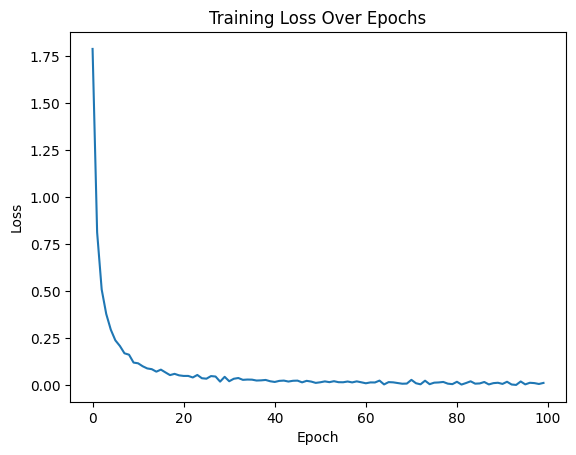

In [13]:
import matplotlib.pyplot as plt
# Đồ thị Loss
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

### Đánh giá mô hình sau huấn luyện

In [27]:
import random
# Lấy một mẫu ngẫu nhiên
model.eval()  # Đặt mô hình vào chế độ đánh giá
with torch.no_grad():
    # Lấy một batch từ val_loader
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = label_to_index(labels).to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Lấy ngẫu nhiên một mẫu từ batch đầu tiên
        random_batch_index = random.randint(0, inputs.size(0) - 1)

        true_label = labels[random_batch_index].item()
        predicted_label = predicted[random_batch_index].item()
        
        print(f"Batch Sample - True Label: {true_label}, Predicted Label: {predicted_label}")
        break  # Chỉ lấy một batch
    
    # Lấy mẫu ngẫu nhiên từ toàn bộ tập dữ liệu
    random_index = random.randint(0, len(val_dataset) - 1)
    random_sample, random_label = val_dataset[random_index]
    random_sample = random_sample.unsqueeze(0).to(device)  # Thêm một chiều batch và chuyển sang device
    random_label = label_to_index([random_label]).to(device)

    random_output = model(random_sample)
    _, random_predicted = torch.max(random_output, 1)

    print(f"Random Dataset Sample - True Label: {random_label.item()}, Predicted Label: {random_predicted.item()}")


Batch Sample - True Label: 1, Predicted Label: 1
Random Dataset Sample - True Label: 16, Predicted Label: 16


# Import testing data

In [15]:
# # Đọc dữ liệu từ file CSV cho tập kiểm tra
# df_test = pd.read_csv('Data_testing_v3.csv')
    
# # Chọn các cột 'x1', 'x2', 'x3', 'x4', 'x5' làm đầu vào và 'y' làm đầu ra
# x_test_data = df_test[['x1', 'x2', 'x3', 'x4', 'x5']]
# y_test_data = df_test['y']

# # Khởi tạo danh sách để lưu trữ dữ liệu đầu vào dưới dạng tensors
# x_test = []

# # Lặp qua từng hàng trong x_test_data
# for index in range(len(x_test_data)):
#     # Lấy hàng thứ index từ DataFrame
#     row = x_test_data.iloc[index]
#     # Chuyển đổi từng giá trị trong hàng thành list
#     x_values = [ast.literal_eval(val) for val in row.values]
#     # Thêm tensor tương ứng vào danh sách x_test
#     x_test.append(torch.tensor(x_values, dtype=torch.float32))

# # Chuyển đổi dữ liệu đầu ra thành tensor PyTorch
# y_test = torch.tensor(y_test_data.values, dtype=torch.long).to(device)

# # Tạo tensor từ danh sách các tensors đầu vào
# X_test = torch.stack(x_test).to(device)

# # In ra kích thước của tensors đầu vào và đầu ra
# print("x_test:", X_test.shape)
# print("y_test:", y_test.shape)

In [16]:
import pandas as pd
import ast
# Đọc dữ liệu từ file CSV vào DataFrame
df = pd.read_csv('data_test_data.csv')

# Chọn chỉ một dòng từ DataFrame
x_sc_list=[]
y_sc_list=[]
for row_index in range(df.shape[0]):
    selected_row = df.iloc[row_index]
    
    # Lấy dữ liệu của các cột 'x' và 'y' từ hàng đã chọn
    x_values = [ast.literal_eval(selected_row[col]) for col in df.columns if col != 'y']
    y_values = [ast.literal_eval(selected_row['y'])]
    # Chuyển đổi dữ liệu thành tensors PyTorch
    X_test = torch.tensor([x_values], dtype=torch.float32)
    Y_test = torch.tensor([y_values], dtype=torch.float32)
    # Kiểm tra kích thước của tensors
    print("Kích thước của X_test của kịch bản ",row_index+1,':', X_test.shape)
    print("Kích thước của Y_test của kịch bản ",row_index+1,':', Y_test.shape)
    x_sc_list.append(X_test)
    y_sc_list.append(Y_test)




Kích thước của X_test của kịch bản  1 : torch.Size([1, 5, 2073])
Kích thước của Y_test của kịch bản  1 : torch.Size([1, 1, 2073])
Kích thước của X_test của kịch bản  2 : torch.Size([1, 5, 1743])
Kích thước của Y_test của kịch bản  2 : torch.Size([1, 1, 1743])
Kích thước của X_test của kịch bản  3 : torch.Size([1, 5, 3367])
Kích thước của Y_test của kịch bản  3 : torch.Size([1, 1, 3367])
Kích thước của X_test của kịch bản  4 : torch.Size([1, 5, 3877])
Kích thước của Y_test của kịch bản  4 : torch.Size([1, 1, 3877])


In [17]:
import torch

# Tensor ban đầu
#tensor = torch.tensor([[[11., 11., 11., 73., 73., 73.]]])

# Trích xuất danh sách các giá trị từ tensor
values = y_sc_list[0].flatten().tolist()

# Chuyển đổi từng giá trị thành số nguyên
r1 = [int(val) for val in values]

# In ra danh sách mới
print(r1)


[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,

In [18]:
# Khởi tạo list ban đầu
list_ban_dau = r1

# Khởi tạo list mới để lưu các giá trị mới
sc1 = []

# Quét qua từng phần tử trong list ban đầu
for gia_tri in list_ban_dau:
    # Kiểm tra xem giá trị đã xuất hiện trong list mới chưa
    if gia_tri not in sc1:
        # Nếu chưa, thêm vào list mới
        sc1.append(gia_tri)

# In list mới
print("List mới sau khi loại bỏ các giá trị trùng lặp:", sc1)

List mới sau khi loại bỏ các giá trị trùng lặp: [11, 12, 21, 22, 31, 32, 34, 62, 64, 92, 94, 93, 84, 83, 74, 73]


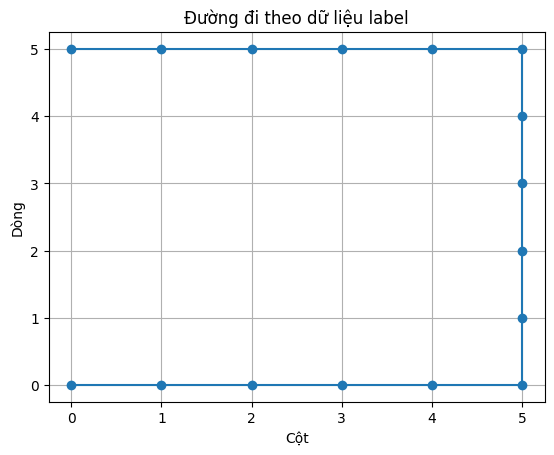

In [19]:
import matplotlib.pyplot as plt

# Khu vực chứa các nhãn
area = [
    [11, 12, 21, 22, 31, 32],
    [13, 14, 23, 24, 33, 34],
    [41, 42, 51, 52, 61, 62],
    [43, 44, 53, 54, 63, 64],
    [71, 72, 81, 82, 91, 92],
    [73, 74, 83, 84, 93, 94]
]

# Dữ liệu label đã cho
labels = sc1

# Tìm tọa độ (dòng và cột) tương ứng với mỗi label
coordinates = [(i, j) for i, row in enumerate(area) for j, val in enumerate(row) if val in labels]

# Sắp xếp tọa độ theo thứ tự của label
coordinates.sort(key=lambda x: labels.index(area[x[0]][x[1]]))

# Lấy ra các tọa độ x và y
x = [coord[1] for coord in coordinates]
y = [len(area) - coord[0] - 1 for coord in coordinates]  # Đảo ngược trục y vì matplotlib vẽ theo cách này

# Vẽ đường đi
plt.plot(x, y, marker='o')
plt.title('Đường đi theo dữ liệu label')
plt.xlabel('Cột')
plt.ylabel('Dòng')
plt.grid(True)
plt.show()

In [20]:
# Đọc dữ liệu từ file CSV cho tập kiểm tra
df_test = pd.read_csv('Data_testing_v4.csv')
    
# Chọn các cột 'x1', 'x2', 'x3', 'x4', 'x5' làm đầu vào và 'y' làm đầu ra
x_test_data = df_test[['x1', 'x2', 'x3', 'x4', 'x5']]
y_test_data = df_test['y']

# Khởi tạo danh sách để lưu trữ dữ liệu đầu vào dưới dạng tensors
x_test = []

# Lặp qua từng hàng trong x_test_data
for index in range(len(x_test_data)):
    # Lấy hàng thứ index từ DataFrame
    row = x_test_data.iloc[index]
    # Chuyển đổi từng giá trị trong hàng thành list
    x_values = [ast.literal_eval(val) for val in row.values]
    # Thêm tensor tương ứng vào danh sách x_test
    x_test.append(torch.tensor(x_values, dtype=torch.float32))

# Chuyển đổi dữ liệu đầu ra thành tensor PyTorch
y_test = torch.tensor(y_test_data.values, dtype=torch.long).to(device)

# Tạo tensor từ danh sách các tensors đầu vào
X_test = torch.stack(x_test).to(device)

# In ra kích thước của tensors đầu vào và đầu ra
print("x_test:", X_test.shape)
print("y_test:", y_test.shape)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

x_test: torch.Size([2073, 5, 10])
y_test: torch.Size([2073])


In [36]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
predictions = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = label_to_index(labels).to(device)
        
        outputs = model(inputs)
        loss = error(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        predictions.extend(predicted.cpu().numpy().tolist())

test_loss /= len(val_loader.dataset)
test_acc = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Hiển thị một số dự đoán ngẫu nhiên
import random
random_indices = random.sample(range(min(len(predictions), len(labels))), 5)
for i in random_indices:
    true_label = index_to_label[labels[i].item()]
    predicted_label = index_to_label[predictions[i]]
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")

Test Loss: 0.0012, Test Accuracy: 0.9996
True Label: 64, Predicted Label: 44
True Label: 42, Predicted Label: 13
True Label: 44, Predicted Label: 12
True Label: 14, Predicted Label: 63
True Label: 23, Predicted Label: 81


In [37]:
# Khởi tạo list ban đầu
list_ban_dau = predictions

# Khởi tạo list mới để lưu các giá trị mới
t1 = []

# Quét qua từng phần tử trong list ban đầu
for gia_tri in list_ban_dau:
    # Kiểm tra xem giá trị đã xuất hiện trong list mới chưa
    if gia_tri not in t1:
        # Nếu chưa, thêm vào list mới
        t1.append(gia_tri)

# In list mới
print("List mới sau khi loại bỏ các giá trị trùng lặp:", t1)

List mới sau khi loại bỏ các giá trị trùng lặp: [22, 12, 26, 11, 28, 27, 3, 1, 25, 6, 2, 29, 15, 5, 0, 34, 13, 7, 31, 35, 17, 36, 24, 9, 8, 32, 4, 20, 16, 14, 10, 21, 30, 33, 18, 19, 23]


In [38]:
# Danh sách ban đầu
initial_list = t1

# Danh sách label
labels = [
    11, 12, 21, 22, 31, 32,
    13, 14, 23, 24, 33, 34,
    41, 42, 51, 52, 61, 62,
    43, 44, 53, 54, 63, 64,
    71, 72, 81, 82, 91, 92,
    73, 74, 83, 84, 93, 94, 0
]

# Lọc danh sách ban đầu chỉ giữ lại các giá trị có trong labels
filtered_list = [value for value in initial_list if value in labels]

print(filtered_list)


[22, 12, 11, 0, 34, 13, 31, 24, 32, 14, 21, 33, 23]


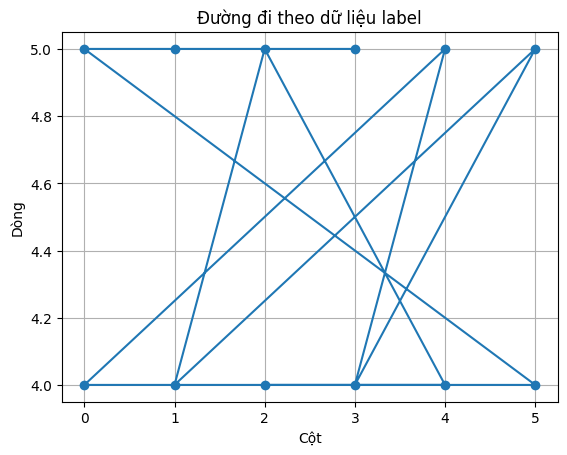

In [39]:
import matplotlib.pyplot as plt

# Khu vực chứa các nhãn
area = [
    [11, 12, 21, 22, 31, 32],
    [13, 14, 23, 24, 33, 34],
    [41, 42, 51, 52, 61, 62],
    [43, 44, 53, 54, 63, 64],
    [71, 72, 81, 82, 91, 92],
    [73, 74, 83, 84, 93, 94]
]

# Dữ liệu label đã cho
labels = filtered_list

# Tìm tọa độ (dòng và cột) tương ứng với mỗi label
coordinates = [(i, j) for i, row in enumerate(area) for j, val in enumerate(row) if val in labels]

# Sắp xếp tọa độ theo thứ tự của label
coordinates.sort(key=lambda x: labels.index(area[x[0]][x[1]]))

# Lấy ra các tọa độ x và y
x = [coord[1] for coord in coordinates]
y = [len(area) - coord[0] - 1 for coord in coordinates]  # Đảo ngược trục y vì matplotlib vẽ theo cách này

# Vẽ đường đi
plt.plot(x, y, marker='o')
plt.title('Đường đi theo dữ liệu label')
plt.xlabel('Cột')
plt.ylabel('Dòng')
plt.grid(True)
plt.show()